# HW 10
#### Author: Daniel Fay
-----------
#### Task:
Exploratory spatial data analysis of summer and winter months of CitiBike data using pysal and geopandas  

### Import Libraries
_________

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn
import statsmodels.api as sm
import shapely
import seaborn as sns
import geopandas as gpd
import pysal as ps
%matplotlib inline

from geopandas import GeoDataFrame
from fiona.crs import from_epsg

### Create CitiBike Ridership by Census Track Dataset
_______________

##### Load Census Track Data

In [82]:
# Load Census Track shape file into geopandas dataframe
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
#ct_shape.set_index(ct_shape.BoroCT2010, inplace=True)
ct_shape.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
0,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016729,POLYGON ((-74.07920577013245 40.64343078374566...
1,5012500,5,Staten Island,I,012500,125,SI22,West New Brighton-New Brighton-St. George,3903,4.954936e+06,10582.855530,POLYGON ((-74.11618948747538 40.62894119691981...
2,5013301,5,Staten Island,E,013301,133.01,SI22,West New Brighton-New Brighton-St. George,3903,7.217847e+05,3428.312676,POLYGON ((-74.11719947139957 40.63456809812987...
3,5019700,5,Staten Island,I,019700,197,SI07,Westerleigh,3903,3.231720e+06,9097.697226,POLYGON ((-74.13122302263596 40.61726518212697...
4,5002002,5,Staten Island,I,002002,20.02,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,8.501224e+06,12591.725901,"POLYGON ((-74.0635056566019 40.60215005483046,..."


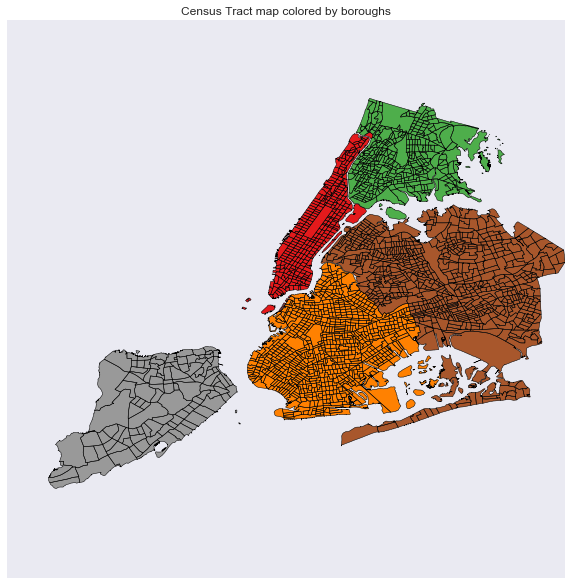

In [83]:
# Visualize shapefile and color by borough
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

##### Load CitiBike Data

In [84]:
# Load citibike csv into pandas dataframe
df_bike_monthly = pd.DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.reset_index(inplace=True)
df_bike_monthly.head()

,starttime,1000,1001,1002,1003,1004,1005,1006,1007,1008,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
0,2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,...,0,0,0,0,0,0,0,0,0,0
1,2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,...,0,0,0,0,0,0,0,0,0,0
2,2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,...,0,0,0,0,0,0,0,0,0,0
3,2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,...,0,0,0,0,0,0,0,0,0,0
4,2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,...,0,0,0,0,0,0,0,0,0,0


##### Load Station Location Data

In [85]:
# Load station data into pandas dataframe
station_id = pd.DataFrame.from_csv('Data/Station_id.csv')
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


In [86]:
# Convert lat and lon columns to geopandas point geometry
station_id['lonlat'] = [(station_id.iloc[i].lon ,station_id.iloc[i].lat ) for i in range(len(station_id))]
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id = gpd.GeoDataFrame(station_id, geometry=station_id.geometry)
station_id.crs = {'init' :'epsg:4326'}
station_id.drop(['lat', 'lon', 'lonlat'], axis=1, inplace=True)
station_id.reset_index(inplace=True)
station_id.columns = ['station', 'geometry']
station_id.station = station_id.station.apply(str)
station_id.head()

,station,geometry
0,1000,POINT (-73.97032517 40.75323098)
1,1001,POINT (-74.00295034600001 40.749717753)
2,1002,POINT (-73.9907647 40.73028666)
3,1003,POINT (-73.99266288 40.71893904)
4,1004,POINT (-73.99200509000001 40.73492695)


### Split CitiBike Data into Summer and Winter Months

In [87]:
# Create winter citibike ridership dataframe (december - february)
winter_months = ['2013-12-31', '2014-01-31', '2014-02-28', 
                 '2014-12-31', '2015-01-31', '2015-02-28',
                 '2015-12-31', '2016-01-31', '2016-02-28']
bike_monthly_winter = df_bike_monthly.loc[df_bike_monthly['starttime'].isin(winter_months)]
bike_monthly_winter.head()

,starttime,1000,1001,1002,1003,1004,1005,1006,1007,1008,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
5,2013-12-31,1299,1650,4081,1686,3046,1575,830,1890,2048,...,0,0,0,0,0,0,0,0,0,0
6,2014-01-31,956,1337,3178,1251,1920,1130,477,1412,1082,...,0,0,0,0,0,0,0,0,0,0
7,2014-02-28,650,960,2920,676,1808,933,508,1045,963,...,0,0,0,0,0,0,0,0,0,0
17,2014-12-31,1052,1304,4501,1783,2985,2091,779,2108,1636,...,0,0,0,0,0,0,0,0,0,0
18,2015-01-31,833,0,3186,1248,1992,1429,442,1499,1366,...,0,0,0,0,0,0,0,0,0,0


In [88]:
# Create summer citibike ridership dataframe (june - august)
summer_months = ['2013-07-31', '2013-08-31', '2014-06-30', '2014-07-31', '2014-08-31', 
               '2015-06-30', '2015-07-31', '2015-08-31', '2016-06-30']
bike_monthly_summer = df_bike_monthly.loc[df_bike_monthly['starttime'].isin(summer_months)]
bike_monthly_summer.head()

,starttime,1000,1001,1002,1003,1004,1005,1006,1007,1008,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
0,2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,...,0,0,0,0,0,0,0,0,0,0
1,2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,...,0,0,0,0,0,0,0,0,0,0
11,2014-06-30,2048,3306,9626,3515,7255,2942,1917,3702,3694,...,0,0,0,0,0,0,0,0,0,0
12,2014-07-31,2252,3216,9825,3509,7014,3224,2195,3732,4042,...,0,0,0,0,0,0,0,0,0,0
13,2014-08-31,2179,3004,10196,3573,7328,3311,2213,4078,4011,...,0,0,0,0,0,0,0,0,0,0


In [89]:
# Take average monthly ridership for each station (Winter)
month_avg_winter = pd.DataFrame(bike_monthly_winter.mean())
month_avg_winter.reset_index(inplace=True)
month_avg_winter.columns = ['station', 'month_avg']
month_avg_winter.head()

,station,month_avg
0,1000,1032.00
1,1001,1177.75
2,1002,3953.75
3,1003,1510.25
4,1004,2423.25


In [90]:
# Take average monthly ridership for each station (Summer)
month_avg_summer = pd.DataFrame(bike_monthly_summer.mean())
month_avg_summer.reset_index(inplace=True)
month_avg_summer.columns = ['station', 'month_avg']
month_avg_summer.head()

,station,month_avg
0,1000,2491.333333
1,1001,3652.111111
2,1002,9708.333333
3,1003,3668.666667
4,1004,6654.444444


##### Merge Station Location and Monthly Average Ridership

In [91]:
# Winter
StaLoc_MonthAvg_Winter = station_id.merge(month_avg_winter, on='station')
StaLoc_MonthAvg_Winter.head()

,station,geometry,month_avg
0,1000,POINT (-73.97032517 40.75323098),1032.00
1,1001,POINT (-74.00295034600001 40.749717753),1177.75
2,1002,POINT (-73.9907647 40.73028666),3953.75
3,1003,POINT (-73.99266288 40.71893904),1510.25
4,1004,POINT (-73.99200509000001 40.73492695),2423.25


In [92]:
# Summer
StaLoc_MonthAvg_Summer = station_id.merge(month_avg_summer, on='station')
StaLoc_MonthAvg_Summer.head()

,station,geometry,month_avg
0,1000,POINT (-73.97032517 40.75323098),2491.333333
1,1001,POINT (-74.00295034600001 40.749717753),3652.111111
2,1002,POINT (-73.9907647 40.73028666),9708.333333
3,1003,POINT (-73.99266288 40.71893904),3668.666667
4,1004,POINT (-73.99200509000001 40.73492695),6654.444444


##### Merge Station Location and Monthly Ridership into Census Track

In [93]:
# Winter
stations_ct_winter = gpd.sjoin(ct_shape, StaLoc_MonthAvg_Winter, how="left", op='intersects')
stations_ct_winter.drop('index_right', axis=1, inplace=True)
stations_ct_winter.set_index('BoroCT2010', inplace=True)
stations_ct_winter.sort_index(inplace=True)
stations_ct_winter.fillna(0, inplace=True)
stations_ct_winter.head()

,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,station,month_avg
BoroCT2010,,,,,,,,,,,,,
1000100,1,Manhattan,I,000100,1,MN99,park-cemetery-etc-Manhattan,3810,1.844421e+06,11023.047911,(POLYGON ((-74.04387761639912 40.6901876753712...,0,0.000
1000201,1,Manhattan,E,000201,2.01,MN28,Lower East Side,3809,9.716282e+05,4748.703650,POLYGON ((-73.98449647076764 40.70950966393941...,0,0.000
1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,1197,398.625
1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,1229,634.875
1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,1329,1131.125


In [94]:
# Summer
stations_ct_summer = gpd.sjoin(ct_shape, StaLoc_MonthAvg_Summer, how="left", op='intersects')
stations_ct_summer.drop('index_right', axis=1, inplace=True)
stations_ct_summer.set_index('BoroCT2010', inplace=True)
stations_ct_summer.sort_index(inplace=True)
stations_ct_summer.fillna(0, inplace=True)
stations_ct_summer.head()

,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,station,month_avg
BoroCT2010,,,,,,,,,,,,,
1000100,1,Manhattan,I,000100,1,MN99,park-cemetery-etc-Manhattan,3810,1.844421e+06,11023.047911,(POLYGON ((-74.04387761639912 40.6901876753712...,0,0.000000
1000201,1,Manhattan,E,000201,2.01,MN28,Lower East Side,3809,9.716282e+05,4748.703650,POLYGON ((-73.98449647076764 40.70950966393941...,0,0.000000
1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,1197,1602.888889
1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,1229,1340.111111
1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,1329,1877.000000


##### Remove Census Tracks that are far away from CitiBike stations

In [95]:
# Winter
stations_ct_winter = (stations_ct_winter[stations_ct_winter
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])
stations_ct_winter.head()

,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,station,month_avg
BoroCT2010,,,,,,,,,,,,,
1000100,1,Manhattan,I,000100,1,MN99,park-cemetery-etc-Manhattan,3810,1.844421e+06,11023.047911,(POLYGON ((-74.04387761639912 40.6901876753712...,0,0.000
1000201,1,Manhattan,E,000201,2.01,MN28,Lower East Side,3809,9.716282e+05,4748.703650,POLYGON ((-73.98449647076764 40.70950966393941...,0,0.000
1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,1197,398.625
1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,1229,634.875
1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,1329,1131.125


In [96]:
# Summer
stations_ct_summer = (stations_ct_summer[stations_ct_summer
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])
stations_ct_summer.head()

,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,station,month_avg
BoroCT2010,,,,,,,,,,,,,
1000100,1,Manhattan,I,000100,1,MN99,park-cemetery-etc-Manhattan,3810,1.844421e+06,11023.047911,(POLYGON ((-74.04387761639912 40.6901876753712...,0,0.000000
1000201,1,Manhattan,E,000201,2.01,MN28,Lower East Side,3809,9.716282e+05,4748.703650,POLYGON ((-73.98449647076764 40.70950966393941...,0,0.000000
1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,1197,1602.888889
1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,1229,1340.111111
1000202,1,Manhattan,E,000202,2.02,MN28,Lower East Side,3809,3.315121e+06,8568.208367,(POLYGON ((-73.98237340572007 40.7055433504376...,1329,1877.000000


##### Visualize Summer and Winter Ridership in each Census Track

/Users/Danny1/anaconda/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


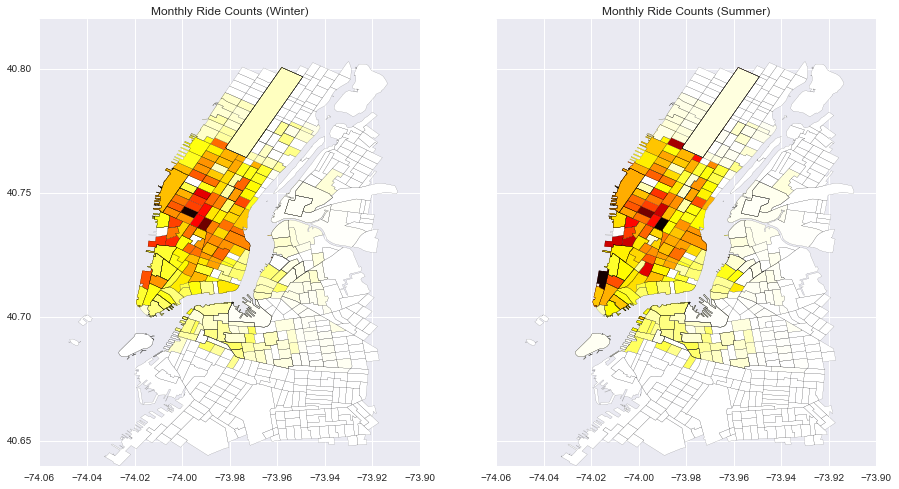

In [97]:
# Winter and Summer side by side visualization
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,8))

stations_ct_winter.plot(column='month_avg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1)
ax1.set_title("Monthly Ride Counts (Winter)")
stations_ct_summer.plot(column='month_avg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax2)
ax2.set_title("Monthly Ride Counts (Summer)")

##### Export Shapefile to Output Folder

In [ ]:
# Export both winter and summer shapefile
path_winter = 'Output/stations_ct_winter.shp'
path_summer = 'Output/stations_ct_summer.shp'
stations_ct_winter.to_file(path_winter)
stations_ct_summer.to_file(path_summer)

### Exploratory Geospatial Analysis
__________

#### Winter

In [ ]:
# Spatial Weights
qW_CT_winter = ps.queen_from_shapefile(path_winter)

In [ ]:
# Matrix of Weights
Wmatrix_winter, ids_winter = qW_CT_winter.full()
Wmatrix_winter

In [ ]:
# Change matrix to be row-standardized
qW_CT_winter.transform = 'r'

In [ ]:
# Spatial Lag
MonthlyRide_winter = stations_ct_winter.month_avg
MonthlyRideLag_winter = ps.lag_spatial(qW_CT_winter, MonthlyRide_winter)

In [ ]:
# Quantiles for mapping
MonthlyRideLagQ10_winter = ps.Quantiles(MonthlyRideLag_winter, k=10)
MonthlyRideLagQ10_winter

In [ ]:
# Visualize Monthly Ride Lags
f, ax = plt.subplots(figsize=(9, 9))
stations_ct_winter.assign(cl=MonthlyRideLagQ10_winter.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles (Winter)")

In [ ]:
# Global Spatial Autocorrelation
b_w, a_w = np.polyfit(MonthlyRide_winter, MonthlyRideLag_winter, 1)
b_w, a_w

In [ ]:
# Moran's I
I_MonthlyRide_winter = ps.Moran(MonthlyRide_winter, qW_CT_winter)
I_MonthlyRide_winter.I, I_MonthlyRide_winter.p_sim

In [ ]:
# KDEplot of all the simulated points
plt.rcParams['figure.figsize']=(14,3)
sns.kdeplot(I_MonthlyRide_winter.sim, shade=True)
plt.vlines(I_MonthlyRide_winter.sim, 0, 1)
plt.vlines(I_MonthlyRide_winter.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In [ ]:
# Local Spatial Autocorrelation
LMo_MonthlyRide_winter = ps.Moran_Local(MonthlyRide_winter, qW_CT_winter, permutations=999)

In [ ]:
# LISA (Local Indicators of Spatial Autocorrelation)
sigs_winter = MonthlyRide_winter[LMo_MonthlyRide_winter.p_sim <= .001]
W_sigs_winter = MonthlyRideLag_winter[LMo_MonthlyRide_winter.p_sim <= .001]
insigs_winter = MonthlyRide_winter[LMo_MonthlyRide_winter.p_sim > .001]
W_insigs_winter = MonthlyRideLag_winter[LMo_MonthlyRide_winter.p_sim > .001]

In [ ]:
# Plot Significant LISA
f, ax = plt.subplots(figsize=(12, 8))
plt.plot(sigs_winter, W_sigs_winter, '.', color='firebrick')
plt.plot(insigs_winter, W_insigs_winter, '.k', alpha=.2)
#plt.text(s='$I = %.3f$' % I_MonthlyRide_winter.I, x=120000, y=5000, fontsize=18)

plt.vlines(MonthlyRide_winter.mean(), MonthlyRideLag_winter.min(), MonthlyRideLag_winter.max(), linestyle='--')

plt.hlines(MonthlyRideLag_winter.mean(), MonthlyRide_winter.min(), MonthlyRide_winter.max(), linestyle='--')

plt.plot(MonthlyRide_winter, a_w + b_w*MonthlyRide_winter, 'r')
plt.title('Moran Scatterplot (Winter)')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

In [ ]:
# Hot and Cold Spots
sig_w = LMo_MonthlyRide_winter.p_sim < 0.01
hotspots_w = LMo_MonthlyRide_winter.q==1 * sig_w
coldspots_w = LMo_MonthlyRide_winter.q==3 * sig_w
print ("Number of Hotspots:", hotspots_w.sum())
print ("Number of Coldspots:", coldspots_w.sum())

In [ ]:
# Visualize Hot and Cold Spots
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold_w = hotspots_w*1 + coldspots_w*2

f, ax = plt.subplots(figsize=(9, 9))
stations_ct_winter.assign(cl=hotcold_w).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Hot and Cold Spots (Winter)")

#### Summer

In [ ]:
# Spatial Weights
qW_CT_summer = ps.queen_from_shapefile(path_summer)

In [ ]:
# Matrix of Weights
Wmatrix_summer, ids_summer = qW_CT_summer.full()
Wmatrix_summer

In [ ]:
# Change matrix to be row-standardized
qW_CT_summer.transform = 'r'

In [ ]:
# Spatial Lag
MonthlyRide_summer = stations_ct_summer.month_avg
MonthlyRideLag_summer = ps.lag_spatial(qW_CT_summer, MonthlyRide_summer)

In [ ]:
# Quantiles for mapping
MonthlyRideLagQ10_summer = ps.Quantiles(MonthlyRideLag_summer, k=10)
MonthlyRideLagQ10_summer

In [ ]:
# Visualize Monthly Ride Lags
f, ax = plt.subplots(figsize=(9, 9))
stations_ct_summer.assign(cl=MonthlyRideLagQ10_summer.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles (Summer)")

In [ ]:
# Global Spatial Autocorrelation
b_s, a_s = np.polyfit(MonthlyRide_summer, MonthlyRideLag_summer, 1)
b_s, a_s

In [ ]:
# Moran's I
I_MonthlyRide_summer = ps.Moran(MonthlyRide_summer, qW_CT_summer)
I_MonthlyRide_summer.I, I_MonthlyRide_summer.p_sim

In [ ]:
# KDEplot of all the simulated points
plt.rcParams['figure.figsize']=(14,3)
sns.kdeplot(I_MonthlyRide_summer.sim, shade=True)
plt.vlines(I_MonthlyRide_summer.sim, 0, 1)
plt.vlines(I_MonthlyRide_summer.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In [ ]:
# Local Spatial Autocorrelation
LMo_MonthlyRide_summer = ps.Moran_Local(MonthlyRide_summer, qW_CT_summer, permutations=999)

In [ ]:
# LISA (Local Indicators of Spatial Autocorrelation)
sigs_summer = MonthlyRide_summer[LMo_MonthlyRide_summer.p_sim <= .001]
W_sigs_summer = MonthlyRideLag_summer[LMo_MonthlyRide_summer.p_sim <= .001]
insigs_summer = MonthlyRide_summer[LMo_MonthlyRide_summer.p_sim > .001]
W_insigs_summer = MonthlyRideLag_summer[LMo_MonthlyRide_summer.p_sim > .001]

In [ ]:
# Plot Significant LISA
f, ax = plt.subplots(figsize=(12, 8))
plt.plot(sigs_summer, W_sigs_summer, '.', color='firebrick')
plt.plot(insigs_summer, W_insigs_summer, '.k', alpha=.2)
#plt.text(s='$I = %.3f$' % I_MonthlyRide_summer.I, x=120000, y=5000, fontsize=18)

plt.vlines(MonthlyRide_summer.mean(), MonthlyRideLag_summer.min(), MonthlyRideLag_summer.max(), linestyle='--')

plt.hlines(MonthlyRideLag_summer.mean(), MonthlyRide_summer.min(), MonthlyRide_summer.max(), linestyle='--')

plt.plot(MonthlyRide_summer, a_w + b_w*MonthlyRide_summer, 'r')
plt.title('Moran Scatterplot (Summer)')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

In [ ]:
# Hot and Cold Spots
sig_s = LMo_MonthlyRide_summer.p_sim < 0.01
hotspots_s = LMo_MonthlyRide_summer.q==1 * sig_w
coldspots_s = LMo_MonthlyRide_summer.q==3 * sig_w
print ("Number of Hotspots:", hotspots_s.sum())
print ("Number of Coldspots:", coldspots_s.sum())

In [ ]:
# Visualize Hot and Cold Spots
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold_s = hotspots_s*1 + coldspots_s*2

f, ax = plt.subplots(figsize=(9, 9))
stations_ct_summer.assign(cl=hotcold_s).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Hot and Cold Spots (Summer)")

## Comparison of Winter and Summer

Both winter and summer months show similar spatial patterns. Both have a positive spatial relationship, which indicates that the surrounding area of each census track shows similar CitiBike ridership. Areas with high ridership are spatially close together and areas with low ridership are spatially closer together. The I statistics for winter and summer are .6599 and .6435, respectively. The slight difference in the I statistics is negligible and thus while total ridership decreases in the winter, the spatial correlation remains approximately the same over the course of the year. 